Create a new folder on Google Drive named data.

The content of these folders is 500 images in black of white of eyes.

The masks folder is 500 masks segmenting the iris, sclera, and pupil.

Image:

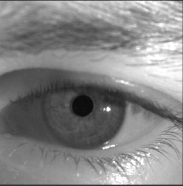

Mask:

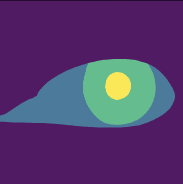

Your folder hierarchy in Google Drive should look like this:

/content/drive/My Drive/data/images/imgs_small

/content/drive/My Drive/data/masks/masks_small

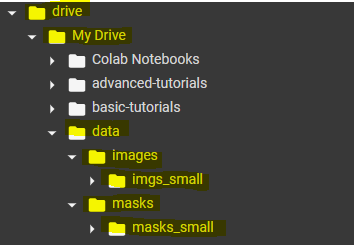

In [3]:
%%capture
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


Import packages we'll need. Chose to use FastAI. Wanted to decrease development time on model so that time could be spent deploying it later.

Muting some of the annoying warnings and making sure that plots will show up in the notebook.

In [4]:
from fastai.vision import *
from fastai.utils.mem import *
from fastai.callbacks.hooks import *
import glob
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

get_ipython().__class__.__name__ = "ZMQInteractiveShell"
get_ipython().__class__.__name__

'ZMQInteractiveShell'

Getting our data and a couple of sanity checks to make sure we're referencing the right path.

In [5]:
path_images = Path('/content/drive/My Drive/data')
path_lbl = path_images
fnames = glob.glob('/content/drive/My Drive/data/images/imgs_small/*.jpg')
lbl_names = glob.glob('/content/drive/My Drive/data/masks/masks_small/*.png')
fnames[1]

'/content/drive/My Drive/data/images/imgs_small/set_10_frame_29.jpg'

In [6]:
lbl_names[20]

'/content/drive/My Drive/data/masks/masks_small/set_12_frame_157.png'

Two functions we will need to run our model. 

The first function, get_y_fn() will map images to masks.

The second function will be used as our accuracy measurement. We are making sure that we are only comparing the predicted mask to the ground truth mask on pixels that are not the "void_code" which is the background. In this case the background is the area outside of the eye itself.

I had commented out a Dice loss function and Dice coefficient metric - with IoU as true the metric was not returning the correct values. I'm guessing the issue is the multiclass nature of the problem. (I'm keeping it in case I can figure it out in the future) After much experimentation the Dice loss function was actually performing worse in predicting on eye images it had never seen.

We'll use accuracy, and F1 score to compare models to previously trained ones since fbeta takes into account precision and recall. We set beta equal to 1 for multi-class segmentation problems. (This is why it's called F1) I use F1-score as a heuristic metric on how well the model is balanced between precision and recall and also as a model comparison metric.

In [0]:
def get_y_fn(x):
    """ Mapping masks to images """
    x = Path(x)
    y = r'/content/drive/My Drive/data/masks/masks_small' + '/' + f'{x.stem}.png'
    return y

def acc_image_seg(input, target):
    """ accuracy measure disregarding the background pixels """
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

# The partial function will make a copy of the targeted function and change the
# value of the function parameters stated. We do this because the metrics list
# passed to unet_learner make function calls.

f1_score = partial(fbeta, beta=1)

# def dice_loss(logits, true, eps=1e-7, reduction='mean'):
#     """Computes the Sørensen–Dice loss.
#     Note that PyTorch optimizers minimize a loss. In this
#     case, we would like to maximize the dice loss so we
#     return the negated dice loss.
#     Args:
#         true: a tensor of shape [B, 1, H, W].
#         logits: a tensor of shape [B, C, H, W]. Corresponds to
#             the raw output or logits of the model.
#         eps: added to the denominator for numerical stability.
#     Returns:
#         dice_loss: the Sørensen–Dice loss.
#     """
#     num_classes = logits.shape[1]
#     if num_classes == 1:
#         true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
#         true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
#         true_1_hot_f = true_1_hot[:, 0:1, :, :]
#         true_1_hot_s = true_1_hot[:, 1:2, :, :]
#         true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
#         pos_prob = torch.sigmoid(logits)
#         neg_prob = 1 - pos_prob
#         probas = torch.cat([pos_prob, neg_prob], dim=1)
#     else:
#         true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
#         true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
#         probas = F.softmax(logits, dim=1)
#     true_1_hot = true_1_hot.type(logits.type())
#     dims = (0,) + tuple(range(2, true.ndimension()))
#     intersection = torch.sum(probas * true_1_hot, dims)
#     cardinality = torch.sum(probas + true_1_hot, dims)
#     dice_loss = (2. * intersection / (cardinality + eps))
#     if reduction == 'mean':
#       return (1 - dice_loss.mean())
#     elif reduction =='sum':
#       return (1 - dice_loss.sum())
#     else:
#       return dice_loss


# # https://forums.fast.ai/t/training-unet-dice-coefficient-1-for-segmentation/56195
# def dice_(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
#     n = targs.shape[0]
#     dice_sum = torch.as_tensor([0.], dtype=torch.float32, device=targs.device)
#     for i in range(1, targs.max()+1):
#         input_flatten = input[:,i-1,:,:].flatten(1,-1).float()
#         targs_flatten = targs.flatten(1,-1).float()
#         input_flatten[input_flatten>0.5], input_flatten[input_flatten<=0.5] = 1., 0.
#         targs_flatten[targs_flatten!=i], targs_flatten[targs_flatten==i] = 0, 1
#         intersect = (input_flatten * targs_flatten).sum(dim=1)
#         union = (input_flatten + targs_flatten).sum(dim=1)
#         if not iou: l = 2. * intersect / union
#         else: l = intersect / (union-intersect+eps)
#         l[union == 0.] = 1
#         dice_sum += l.mean()
#     return dice_sum / targs.max()

# dice_coeff = partial(dice_, iou=True)

Let's check how much GPU memory we have. 
We'll change our batch size according to this. 

To use Google Colab's free GPU, please go to "Runtime" -> "Change Runtime Type" -> Change "Hardware Accelerator" to GPU.

In [8]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200:
    bs = 8
else:
    bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


Converting mask and dividing the size in half for training.

[408 408]


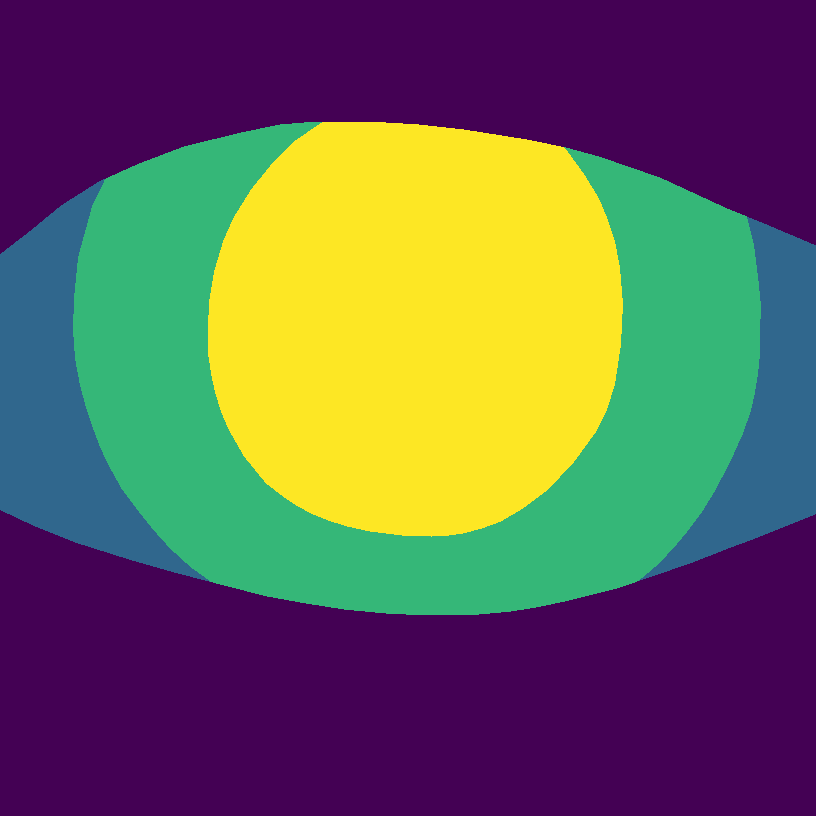

In [9]:
img_f = fnames[3]

mask = open_mask(get_y_fn(img_f), convert_mode='L')

src_size = np.array(mask.shape[1:])

filter_func = lambda x: str(x) in fnames

size = src_size // 2

print(size)

#another sanity check
mask

Instantiate data classes to pass to FastAi's unet_learner object. 

In [0]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, convert_mode='L')


class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

# Our class codes to be one-hot encoded
codes = ['Background', 'Sclera', 'Iris', 'Pupil']

src = (SegItemListCustom.from_folder(path_images)
       .filter_by_func(filter_func)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

Enumerating our classes to predict and naming our void_code. Instantiating unet_learner object.

In [11]:
name2id = {v: k for k, v in enumerate(codes)}
void_code = name2id['Background']
learn = unet_learner(data, models.resnet34, metrics=[acc_image_seg, f1_score])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 28.6MB/s]


Find the right learning rate and apply it to our model training.

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-05
Min loss divided by 10: 1.45E-04
5.248074602497728e-05


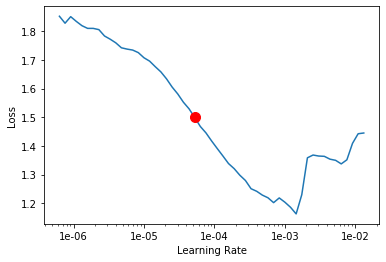

In [27]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
print(min_grad_lr)
lr = 1e-4

Train our model for 50 epochs and save the weights to 'unet_eye_1'.

If you want to predict without retraining model you can load the weights using the commented out command below.

In [28]:
learn.fit_one_cycle(100, slice(lr), pct_start=0.9)
learn.save('unet_eye_seg')
learn.export('unet_eye_seg_final.pkl')

# loading model and predicting
# learn.load('unet_eye_seg')

epoch,train_loss,valid_loss,acc_image_seg,fbeta,time
0,1.114080,0.835142,0.172950,0.731269,01:43
1,0.770127,0.478510,0.556701,0.628788,00:59
2,0.567495,0.366140,0.705468,0.590205,00:58
3,0.449150,0.297213,0.788990,0.550704,00:58
4,0.361318,0.248693,0.812170,0.525074,00:58
5,0.306408,0.220750,0.844444,0.506141,00:59
6,0.271999,0.199164,0.831848,0.505865,00:59
7,0.254491,0.180089,0.848819,0.497781,00:58
8,0.227872,0.162737,0.870592,0.489111,00:58
9,0.204810,0.147837,0.897314,0.480257,00:58


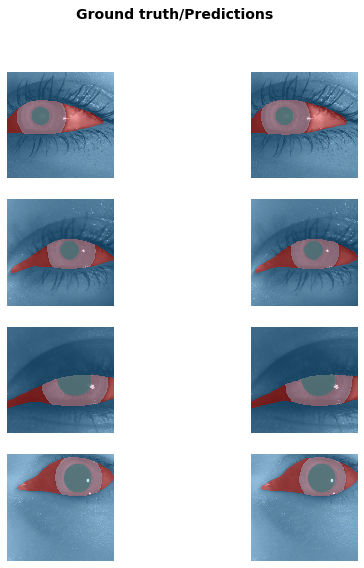

In [16]:
# learn.load('unet_eye_seg')
learn.show_results(rows=6, figsize=(8,9))

In [0]:
# learn=load_learner(Path('/content/drive/My Drive/data'), 'unet_eye_seg_model_dice_iou')
# learn=load_learner(Path('/content/drive/My Drive/data'), 'unet_eye_seg_model')

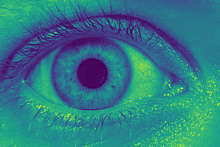

In [21]:
learn.load('unet_eye_seg')
# arr = open_image('/content/drive/My Drive/data/eye_test_1.jpg', convert_mode='L')
arr = open_image('/content/drive/My Drive/data/human-eye-2.jpg', convert_mode='L')
# arr= open_image('/content/drive/My Drive/data/images/imgs_small/set_10_frame_19.jpg', convert_mode='L')
arr

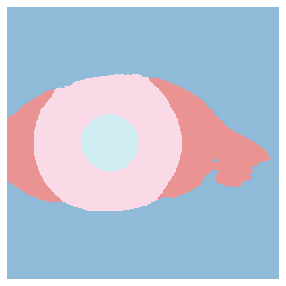

In [22]:
prediction = learn.predict(arr)
prediction[0].show(figsize=(5,5))